In [2]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import cupy as cp
import scipy.io
import math
from scipy.sparse import csc_matrix
import numpy.matlib
import matplotlib.pyplot as plt

In [3]:
cp.cuda.Device(1).use()

In [4]:
def M_forward(M,c,gpu = False):
    if gpu:
        xp = cp
    else:
        xp = np
    return xp.matmul(M,c)

def C_forward(C,m,gpu = False):
    if gpu:
        xp = cp
    else:
        xp = np
    return xp.matmul(m,C)

def M_adjoint(M,x,gpu = False):
    if gpu:
        xp = cp
    else:
        xp = np
    return xp.matmul(M.T.conj(),x)

def C_adjoint(C,x,gpu = False):
    if gpu:
        xp = cp
    else:
        xp = np
    return xp.matmul(x,C.T.conj())



def soft_thresh_complex(x, l,gpu = False):
    if gpu:
        xp = cp
    else:
        xp = np
    return xp.sign(abs(x)) * xp.maximum(xp.abs(x) - l, 0.)*xp.exp(1j*xp.angle(x))

In [26]:
def R_forward(im,patch_no,patch_size,stride_length):
    [frames,n,m]=im.shape
    n_patch_per_side=math.floor((n-patch_size)/stride_length)+1
    row_patch_no=math.floor((patch_no-1)/n_patch_per_side)
    column_patch_no=(patch_no-1)%n_patch_per_side
    crop=im[:,int(row_patch_no*stride_length):int(row_patch_no*stride_length+patch_size),int(column_patch_no*stride_length):int(column_patch_no*stride_length+patch_size)]
    crop=crop.reshape((frames*patch_size*patch_size,1))
    return crop
def R_adjoint(crop,patch_no,im_size,im_frames,stride_length):
    [a,b]=crop.shape
    patch_size=int((a/im_frames)**(1/2))
#     print(patch_size)
    crop=crop.reshape((im_frames,patch_size,patch_size))
    n_patch_per_side=math.floor((im_size-patch_size)/stride_length)+1
    row_patch_no=math.floor((patch_no-1)/n_patch_per_side)
    column_patch_no=(patch_no-1)%n_patch_per_side
    padded=cp.zeros((im_frames,im_size,im_size),dtype=cp.complex)
    padded[:,int(row_patch_no*stride_length):int(row_patch_no*stride_length+patch_size),int(column_patch_no*stride_length):int(column_patch_no*stride_length+patch_size)]=crop
    return padded


def powermethods(matrix_A,iterations = 10):
    max_eig=0
    for i in range(iterations):
        c = cp.random.rand(32*32,1)
        frwrd=M_forward(matrix_A,c,gpu = True)
        mag_c=cp.dot(cp.transpose(c),c)
        eig=cp.dot(cp.transpose(frwrd),frwrd)/mag_c
        eig = eig[0][0]
#         print(eig)
        max_eig=max(eig,max_eig)
#         print(max_eig)
        
    return float(abs(max_eig))

def modelCforward(M,C):
    # C shape: 1,256,256
    # M shape: 225,24,1032,1032
    patchnum = 25
    result=cp.zeros((24,96,96),dtype=cp.complex)
    for i in range(patchnum):
        M_current=cp.array(M[i,:,:,:].reshape(24*1024,1024))
        patch=R_forward(C,patch_no=i+1,stride_length=16,patch_size=32)
        res = M_forward(M=M_current,c=patch,gpu=True)
#         print(R_adjoint(crop=res,im_frames=24,im_size=256,patch_no=i+1,stride_length=16) )
        result+=R_adjoint(crop=res,im_frames=24,im_size=96,patch_no=i+1,stride_length=16) 
    return result
def modelCadjoint(Im,M):
    # Im shape: (24,256,256)
    # M shape: 225,24,1032,1032
    patch_c = cp.zeros((225,96,96),dtype=cp.complex)
    for i in range(25):
        patch = R_forward(Im,patch_no=i+1,patch_size=32,stride_length=16)
        M_patch = cp.array(M[i,:,:,:].reshape(24*1024,1024))
        c_est = M_adjoint(M_patch,patch,gpu=True)
        radj = R_adjoint(c_est,im_frames=1,patch_no=i+1,stride_length=16,im_size=96)  
        patch_c[i,:,:] = radj.squeeze()
    return patch_c.sum(axis=0)[None,:,:]
def modelMadjoint(Im,C):
    # C shape: (1,256,256)
    # Im shape: (24,256,256)
    patch_m = np.zeros((25,24,1024,1024),dtype=cp.complex)
    for i in range(25):
        patch = R_forward(Im,patch_no=i+1,patch_size=32,stride_length=16)
        C_patch = R_forward(C,patch_no=i+1,patch_size=32,stride_length=16)
        cadj = C_adjoint(C_patch,patch,gpu=True).reshape(24,1024,1024)
        patch_m[i,:,:,:] = cp.asnumpy(cadj)
    return patch_m

In [6]:
def sensforward(LPS_image,sensmaps):
    # LPS (256*24,256)
    # sensmaps (256,256,12)
    LPS = LPS_image.reshape(24,96,96).transpose(1,2,0)
    return LPS[:,:,:,None]*sensmaps[:,:,None,:]
def fftforward(sensmaps):
    # sensmaps (256,256,24,12)
    return sp.fft(sensmaps,axes=(0,1))
def maskforward(fftout,mask):
    # fftout (256,256,24,12)
    # mask (256,256,24,12)
    return fftout*mask
def forwardmodel(LPS_image,sensmaps,mask):
    return maskforward(fftforward(sensforward(LPS_image,sensmaps)),mask)
def maskadjoint(kspace,mask):
    return kspace*mask
def fftadjoint(maskout):
    return sp.ifft(maskout,axes=(0,1))
def sensadjoint(fftout,sensmaps):
    ssp = sensmaps[:,:,None,:].conj()
    return cp.sum(fftout*ssp,axis=3)
def adjointmodel(kspace,sensmaps,mask):
    return sensadjoint(fftadjoint(maskadjoint(kspace,mask)),sensmaps)

In [27]:
def FourierCforward(M,C,sensmaps,mask):
    re_image = modelCforward(M,C)
    return forwardmodel(re_image,sensmaps,mask)
def FourierCadjoint(kspace,sensmaps,mask,M):
    ims = adjointmodel(kspace,sensmaps,mask).transpose(2,0,1)
#     print(ims.shape)
    return modelCadjoint(ims,M)
def FourierMadjoint(kspace,sensmaps,mask,C):
    ims = adjointmodel(kspace,sensmaps,mask).transpose(2,0,1)
    return modelMadjoint(ims,C)

In [63]:
im2 =  scipy.io.loadmat("images.mat")

In [64]:
im2["L"]

AttributeError: 'dict' object has no attribute 'shape'

<IPython.core.display.Javascript object>


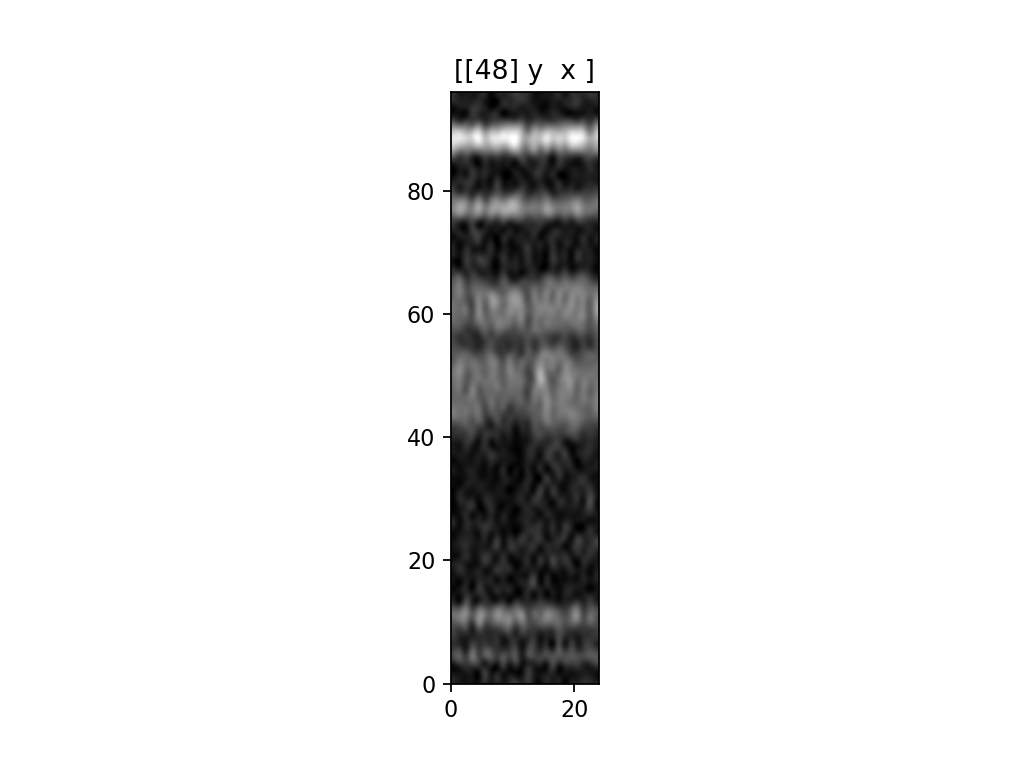

<IPython.core.display.Javascript object>


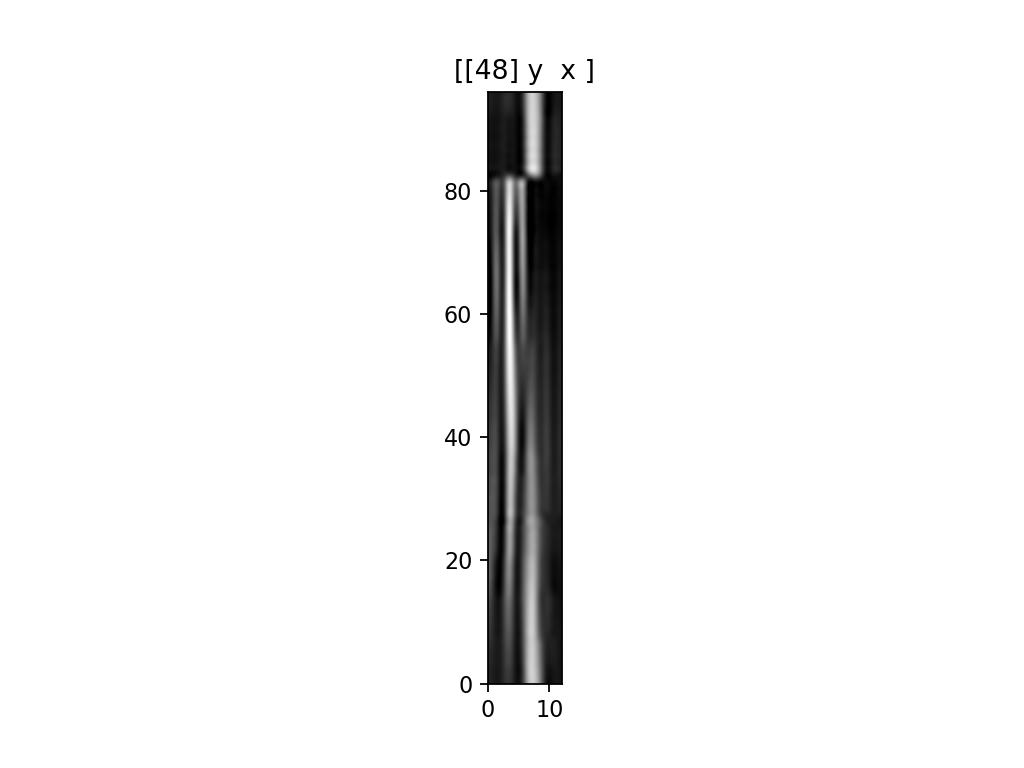

In [19]:
kspace = scipy.io.loadmat("cardiac_cine_R6.mat")
sensmaps = kspace["b1"][::-1,::-1]
raw_data = kspace["kdata"]


# Crop the ksapce
raw_data_lowres = raw_data[128-48:128+48,128-48:128+48,:,:]
# raw_data_lowres = P1
mask_lowres = abs(raw_data_lowres)>0
im_lowres = sp.rss(sp.ifft(raw_data_lowres,axes=(0,1)),axes=3)
pl.ImagePlot(im_lowres)

sens_kspace = sp.fft(sensmaps,axes=(0,1))
sens_kspace_low = sens_kspace[128-48:128+48,128-48:128+48,:]
sens_low = sp.ifft(sens_kspace_low,axes=(0,1))
pl.ImagePlot(sens_low)
# np.save("sens_low.np",sens_low)

In [23]:
# convert array to cupy
raw_data_lowres = cp.array(raw_data_lowres)
sens_low = cp.array(sens_low)
mask_lowres = cp.array(mask_lowres)

In [10]:
imgs = adjointmodel(raw_data_lowres,sens_low,mask_lowres)

In [12]:
C0 = imgs[:,:,0][None,:,:]/10
M0 = np.matlib.repmat(np.eye(32*32,dtype=np.complex),25*24,1).reshape(25,24,1024,1024)

In [14]:
P1 = FourierCforward(M0,C0,sens_low,mask_lowres)

In [24]:
P2 = FourierCadjoint(raw_data_lowres,sens_low,mask_lowres,M0)

In [28]:
P3 = FourierMadjoint(raw_data_lowres,sens_low,mask_lowres,C0)

<IPython.core.display.Javascript object>


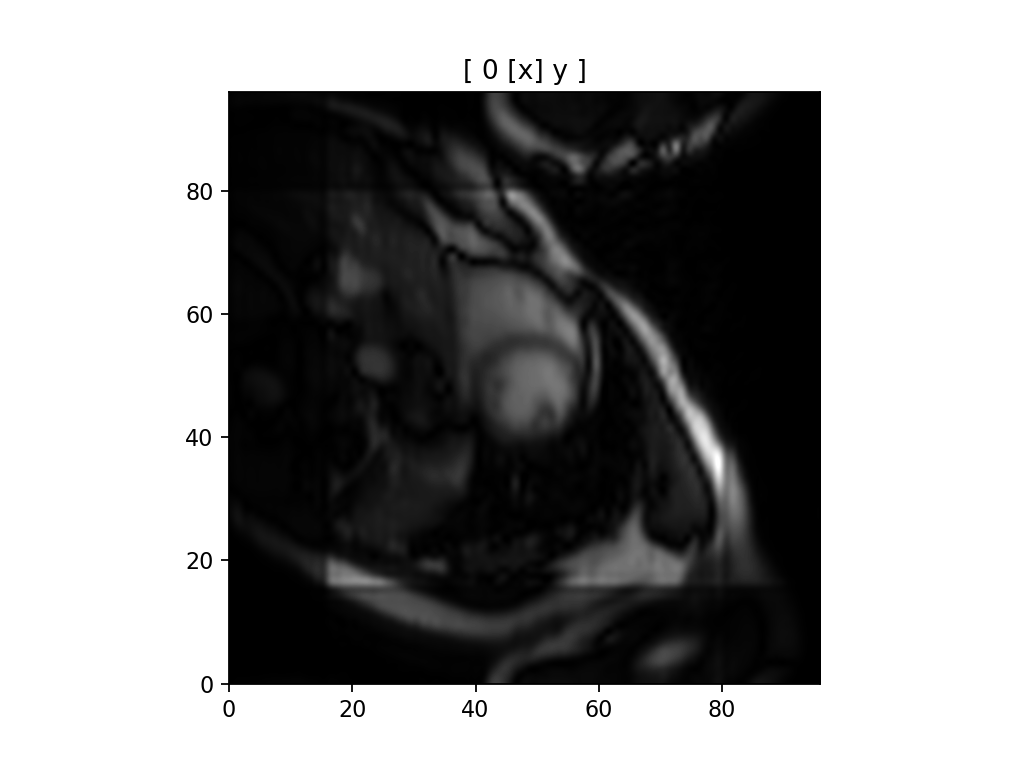

In [25]:
pl.ImagePlot(P2)

In [38]:
def ista(C1,M1,sensmaps,mask,L,lamda,x,gpu = False,outer_iteration = 2,inner_iterations = 10):
    if gpu:
        xp = cp
    else:
        xp = np
    C0=C1
    M0=M1
    converge = []
    print(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x))
#     patch_m = cp.zeros((225,256,256),dtype=cp.complex)
    for i in range(outer_iteration):
        print('Iteration no:'+str(i))
        for j in range(inner_iterations):
            print(j)
            C0 = C0 - (1/L)*FourierCadjoint(FourierCforward(M0,C0,sensmaps,mask)-x,sensmaps,mask,M0)
#             C01 = soft_thresh_complex(w,lamda/L,gpu = gpu)
            converge.append(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x))
#             C0 = C01
            print(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x),"ekin_1")
        for t in range(inner_iterations):
            print(t)
#             patch_m=FourierMadjoint(FourierCforward(M,C,sensmaps,mask)-x,C0)
            M0 = M0 - (1/1000)*FourierMadjoint(FourierCforward(M0,C0,sensmaps,mask)-x,sensmaps,mask,C0)
#             print(C_adjoint(C0,C_forward(C0,M0,gpu = gpu)-x,gpu = gpu))
            #M01 = soft_thresh_complex(M01,lamda/10000,gpu = gpu)
            converge.append(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x))
            print(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x),"ekin")
    
            
#     save("M_patchwise")
    return M0,C0,converge

In [56]:
def fista(C1,M1,sensmaps,mask,L,lamda,x,gpu = False,outer_iteration = 2,inner_iterations = 10):
    if gpu:
        xp = cp
    else:
        xp = np
    C0=C1
    M0=M1
    converge = []
    cp.save("../../patchwise_dynamic_recon_data/M0_fista_0_05.npy",M0)
    cp.save("../../patchwise_dynamic_recon_data/C0_fista_0_05.npy",C0)
    cp.save("../../patchwise_dynamic_recon_data/converge_fista_0_05.npy",np.array(converge))
    print(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x))
#     patch_m = cp.zeros((225,256,256),dtype=cp.complex)
    for i in range(outer_iteration):
        print('Iteration no:'+str(i))
        for j in range(inner_iterations):
            print(j)
            C0 = C0 - (1/L)*FourierCadjoint(FourierCforward(M0,C0,sensmaps,mask)-x,sensmaps,mask,M0)
#             C01 = soft_thresh_complex(w,lamda/L,gpu = gpu)
            converge.append(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x))
#             C0 = C01
            print(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x),"ekin_1")
        Q0 = M0
        vk = 1
        for t in range(inner_iterations):
            print(t)
#             patch_m=FourierMadjoint(FourierCforward(M,C,sensmaps,mask)-x,C0)
            wk = Q0 - (1/1000)*FourierMadjoint(FourierCforward(Q0,C0,sensmaps,mask)-x,sensmaps,mask,C0)
            M01 = soft_thresh_complex(wk,lamda/L)
            vk1 = (1+np.sqrt(1+4*vk*vk))/2
            jk = (vk-1)/vk1
            Q0 = M01+jk*(M01-M0)
            vk = vk1
            
#             print(C_adjoint(C0,C_forward(C0,M0,gpu = gpu)-x,gpu = gpu))
            #M01 = soft_thresh_complex(M01,lamda/10000,gpu = gpu)
            converge.append(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x))
            M0 = M01
            print(xp.linalg.norm(FourierCforward(M0,C0,sensmaps,mask)-x),"ekin")
        cp.save("../../patchwise_dynamic_recon_data/M0_fista_0_05.npy",M0)
        cp.save("../../patchwise_dynamic_recon_data/C0_fista_0_05.npy",C0)
        cp.save("../../patchwise_dynamic_recon_data/converge_fista_0_05.npy",np.array(converge))
            
#     save("M_patchwise")
    return M0,C0,converge

In [ ]:
def fista_kspace(C1,M1,L,lamda,CS,x,N,sens,mask):
    C00=C1
    M00=M1
    converge = []
    for i in range(N):
#         L = float(cp.linalg.eigvalsh(M0.T.dot(M0))[-1])
        P0 = C00
        tk = 1
        for j in range(100):
#             print(j)
            W00 = P0 - (1/L)*M_adjoint(M00,adjointmodel(forwardmodel(M_forward(M00,P0),sens,mask)-x,sens,mask).transpose(2,0,1).reshape(24*256,256))
            w = dwt2(cp.asnumpy(W00))
            W01 = soft_thresh_complex_np(w,CS/L)
            C01 = cp.asarray(idwt2(W01))
            tk1 = (1+np.sqrt(1+4*tk*tk))/2
            bk = (tk-1)/tk1
            P0 = C01+bk*(C01-C00)
            converge.append(cp.linalg.norm(forwardmodel(M_forward(M00,C00),sens,mask)-x))
            C00 = C01
            tk = tk1
        Q0 = M00
        vk = 1
#         L = float(cp.linalg.eigvalsh(C0.T.dot(C0))[-1])
        for t in range(100):
            wk = Q0 - (1/L)*C_adjoint(C00,adjointmodel(forwardmodel(C_forward(C00,Q0),sens,mask)-x,sens,mask).transpose(2,0,1).reshape(24*256,256))
            M01 = soft_thresh_complex(wk,lamda/L)
            vk1 = (1+np.sqrt(1+4*vk*vk))/2
            jk = (vk-1)/vk1
            Q0 = M01+jk*(M01-M00)
            vk = vk1
            converge.append(cp.linalg.norm(forwardmodel(C_forward(C00,M00),sens,mask)-x))
            M00 = M01
        print(cp.linalg.norm(forwardmodel(C_forward(C00,M00),sens,mask)-x))
        cp.save("M11.npy",M00)
        cp.save("C11.npy",C00)
        cp.save("converge1.npy",converge)
        
    return M00,C00,converge

In [39]:
M1,C1,converge=ista(C0,M0,sens_low,mask_lowres,10000,0.01,raw_data_lowres,gpu = True,outer_iteration=2,inner_iterations=10)

392.6731152544143
Iteration no:0
0
286.9686592776024 ekin_1
1
215.06863727737834 ekin_1
2
166.38665927406234 ekin_1
3
133.51908649543512 ekin_1
4
111.25227107749083 ekin_1
5
95.94555094489962 ekin_1
6
85.1251753104596 ekin_1
7
77.17324476747122 ekin_1
8
71.06921187473193 ekin_1
9
66.1850442453726 ekin_1
0
56.0168116698337 ekin
1
48.191801471277735 ekin
2
42.13650234538224 ekin
3
37.41732130255457 ekin
4
33.706929501810784 ekin
5
30.75912289621 ekin
6
28.389560519124547 ekin
7
26.460779353411453 ekin
8
24.870515799028386 ekin
9
23.542686939395733 ekin
Iteration no:1
0
22.99964058619619 ekin_1
1
22.543078318207392 ekin_1
2
22.149584734038992 ekin_1
3
21.804083360971 ekin_1
4
21.49647961348901 ekin_1
5
21.219737260534718 ekin_1
6
20.96875701630914 ekin_1
7
20.73970801594316 ekin_1
8
20.529618894103265 ekin_1
9
20.336120598358644 ekin_1
0
19.533196646314664 ekin
1
18.835267287804786 ekin
2
18.22363653662969 ekin
3
17.68377428179517 ekin
4
17.20421216271029 ekin
5
16.775770968754298 ekin
6


In [62]:
np.array(converge2)[-1]

array(10.54183072)

<IPython.core.display.Javascript object>


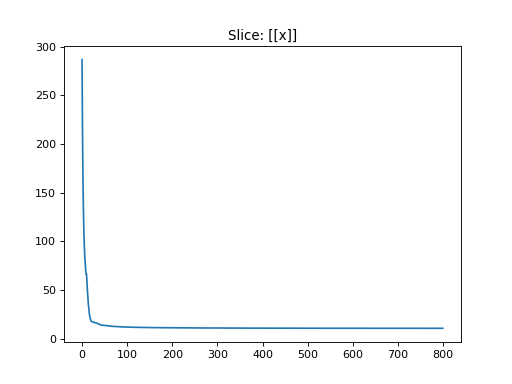

In [61]:
pl.LinePlot(np.array(converge2))

In [ ]:
M2,C2,converge2=fista(C0,M0,sens_low,mask_lowres,10000,0.05,raw_data_lowres,gpu = True,outer_iteration=40,inner_iterations=10)

392.6731152544143
Iteration no:0
0
286.9686592776024 ekin_1
1
215.06863727737834 ekin_1
2
166.38665927406234 ekin_1
3
133.51908649543512 ekin_1
4
111.25227107749083 ekin_1
5
95.94555094489962 ekin_1
6
85.1251753104596 ekin_1
7
77.17324476747122 ekin_1
8
71.06921187473193 ekin_1
9
66.1850442453726 ekin_1
0
56.52280880715868 ekin
1
49.08924995347712 ekin
2
41.78179659564471 ekin
3
35.333421953854796 ekin
4
30.113475280177127 ekin
5
26.154328634012895 ekin
6
23.252759909713774 ekin
7
21.120557823340366 ekin
8
19.508283311165332 ekin
9
18.251327959725717 ekin
Iteration no:1
0
17.8787180828499 ekin_1
1
17.57899812014617 ekin_1
2
17.331122611283618 ekin_1
3
17.121560809176984 ekin_1
4
16.94129370295415 ekin_1
5
16.784085488258626 ekin_1
6
16.64547095807221 ekin_1
7
16.522148503800665 ekin_1
8
16.411606498455598 ekin_1
9
16.311886708490864 ekin_1
0
16.132030688902006 ekin
1
15.976099521025416 ekin
2
15.798805922651072 ekin
3
15.606422526148846 ekin
4
15.402069831314487 ekin
5
15.1875809975163

In [41]:
FM=modelCforward(M1,C1)

<IPython.core.display.Javascript object>


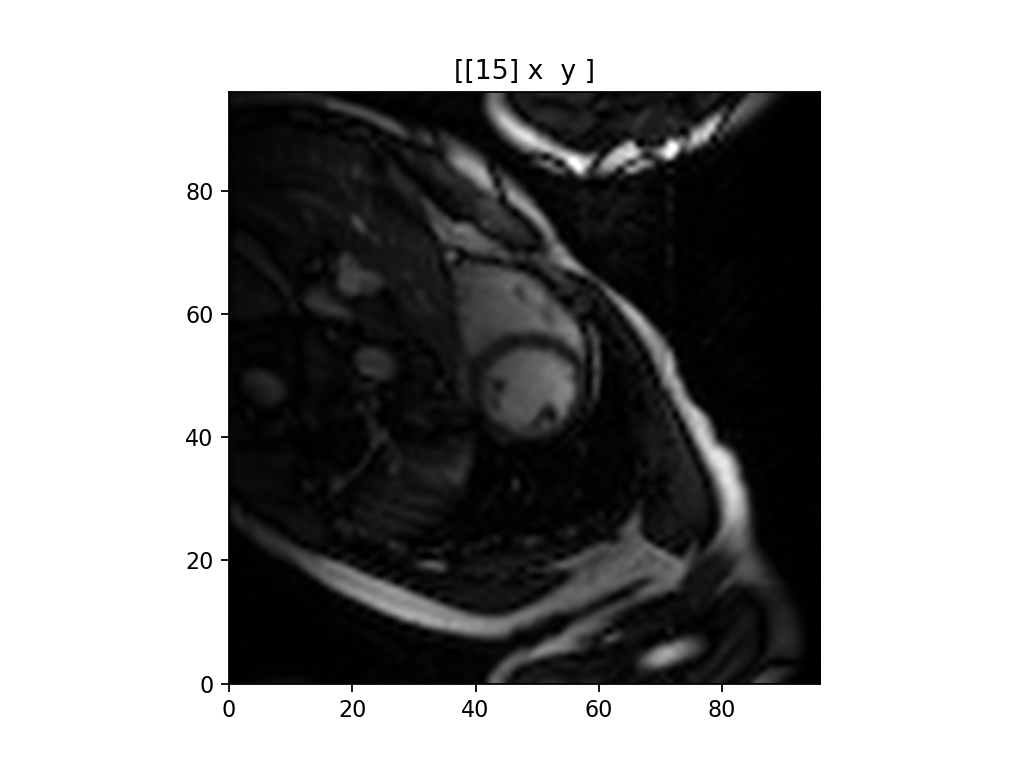

In [45]:
pl.ImagePlot(FM)

In [7]:
def ista_kspace(C1,M1,L,lamda,CS,x,N,sens,mask):
    C0=C1
    M0=M1
    converge = []
    for i in range(N):
#         L = float(cp.linalg.eigvalsh(M0.T.dot(M0))[-1])
        for j in range(100):
#             print(j)
            C01 = C0 - (1/L)*M_adjoint(M0,adjointmodel(forwardmodel(M_forward(M0,C0),sens,mask)-x,sens,mask).transpose(2,0,1).reshape(24*256,256))
            w = dwt2(cp.asnumpy(C01))
            C00 = soft_thresh_complex_np(w,CS/L)
            C01 = cp.asarray(idwt2(C00))
            converge.append(cp.linalg.norm(forwardmodel(M_forward(M0,C0),sens,mask)-x))
            C0 = C01
#         L = float(cp.linalg.eigvalsh(C0.T.dot(C0))[-1])
        for t in range(100):
            w = M0 - (1/L)*C_adjoint(C0,adjointmodel(forwardmodel(C_forward(C0,M0),sens,mask)-x,sens,mask).transpose(2,0,1).reshape(24*256,256))
            M01 = soft_thresh_complex(w,lamda/L)
            converge.append(cp.linalg.norm(forwardmodel(C_forward(C0,M0),sens,mask)-x))
            M0 = M01
        print(cp.linalg.norm(forwardmodel(C_forward(C0,M0),sens,mask)-x))
        cp.save("M1.npy",M0)
        cp.save("C1.npy",C0)
        cp.save("converge1.npy",converge)
        
    return M0,C0,converge

# def fista_kspace(C1,M1,L,lamda,CS,x,N,sens,mask):
#     C00=C1
#     M00=M1
#     converge = []
#     for i in range(N):
# #         L = float(cp.linalg.eigvalsh(M0.T.dot(M0))[-1])
#         P0 = C00
#         tk = 1
#         for j in range(100):
# #             print(j)
#             W00 = P0 - (1/L)*M_adjoint(M00,adjointmodel(forwardmodel(M_forward(M00,P0),sens,mask)-x,sens,mask).transpose(2,0,1).reshape(24*256,256))
#             w = dwt2(cp.asnumpy(W00))
#             W01 = soft_thresh_complex_np(w,CS/L)
#             C01 = cp.asarray(idwt2(W01))
#             tk1 = (1+np.sqrt(1+4*tk*tk))/2
#             bk = (tk-1)/tk1
#             P0 = C01+bk*(C01-C00)
#             converge.append(cp.linalg.norm(forwardmodel(M_forward(M00,C00),sens,mask)-x))
#             C00 = C01
#             tk = tk1
#         Q0 = M00
#         vk = 1
# #         L = float(cp.linalg.eigvalsh(C0.T.dot(C0))[-1])
#         for t in range(100):
#             wk = Q0 - (1/L)*C_adjoint(C00,adjointmodel(forwardmodel(C_forward(C00,Q0),sens,mask)-x,sens,mask).transpose(2,0,1).reshape(24*256,256))
#             M01 = soft_thresh_complex(wk,lamda/L)
#             vk1 = (1+np.sqrt(1+4*vk*vk))/2
#             jk = (vk-1)/vk1
#             Q0 = M01+jk*(M01-M00)
#             vk = vk1
#             converge.append(cp.linalg.norm(forwardmodel(C_forward(C00,M00),sens,mask)-x))
#             M00 = M01
#         print(cp.linalg.norm(forwardmodel(C_forward(C00,M00),sens,mask)-x))
#         cp.save("M11.npy",M00)
#         cp.save("C11.npy",C00)
#         cp.save("converge1.npy",converge)
        
#     return M00,C00,converge